In [77]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Restaurantes por distrito / barrio

Cargamos los mapas de Madrid por distritos y barrios en un GeoDataFrame.

In [78]:
madrid = gpd.read_file('Distritos.shp')
barrios_madrid = gpd.read_file('Barrios.shx')

Asignamos a cada distrito y barrio su correspondiente nombre en los GeoDataFrames.

In [79]:
madrid["NOMBRE_DISTRITO"] = ["Centro", "Arganzuela", "Retiro", "Salamanca", "Chamartin",
               "Tetuan", "Chamberi", "Fuencarral-El Pardo", "Moncloa-Aravaca",
               "Latina", "Carabanchel", "Usera", "Puente de Vallecas", "Moratalaz",
               "Ciudad Lineal", "Hortaleza", "Villaverde", "Villa de Vallecas",
               "Vicalvaro", "San Blas - Canillejas", "Barajas"]

lista_barrios = [
    # Distrito 1: Centro
    "Palacio", "Embajadores", "Cortes", "Justicia", "Universidad", "Sol",

    # Distrito 2: Arganzuela
    "Imperial", "Acacias", "Chopera", "Legazpi", "Delicias", "Palos de Moguer", "Atocha",

    # Distrito 3: Retiro
    "Pacífico", "Adelfas", "Estrella", "Ibiza", "Jerónimos", "Niño Jesús",

    # Distrito 4: Salamanca
    "Recoletos", "Goya", "Fuente del Berro", "Guindalera", "Lista", "Castellana",

    # Distrito 5: Chamartín
    "El Viso", "Prosperidad", "Ciudad Jardín", "Hispanoamérica", "Nueva España", "Castilla",

    # Distrito 6: Tetuán
    "Bellavista-Almenara", "Cuatro Caminos", "Castillejos", "Almenara", "Valdeacederas", "Berruguete",

    # Distrito 7: Chamberí
    "Gaztambide", "Argüelles", "Ríos Rosas", "Trafalgar", "Almagro", "Vallehermoso",

    # Distrito 8: Fuencarral-El Pardo
    "El Pardo", "Fuentelarreina", "Peñagrande", "Barrio del Pilar", "La Paz", "Valverde", "Mirasierra", "El Goloso",

    # Distrito 9: Moncloa-Aravaca
    "Casa de Campo", "Argüelles", "Ciudad Universitaria", "Valdezarza", "Valdemarín", "El Plantío", "Aravaca",

    # Distrito 10: Latina
    "Los Cármenes", "Puerta del Ángel", "Lucero", "Aluche", "Campamento", "Cuatro Vientos", "Las Águilas",

    # Distrito 11: Carabanchel
    "Comillas", "Opañel", "San Isidro", "Vista Alegre", "Puerta Bonita", "Buenavista", "Abrantes",

    # Distrito 12: Usera
    "Orcasur", "Orcasitas", "San Fermín", "Almendrales", "Moscardó", "Zofío", "Pradolongo",

    # Distrito 13: Puente de Vallecas
    "Entrevías", "San Diego", "Palomeras Bajas", "Palomeras Sureste", "Portazgo", "Numancia",

    # Distrito 14: Moratalaz
    "Pavones", "Horcajo", "Marroquina", "Media Legua", "Fontarrón", "Vinateros",

    # Distrito 15: Ciudad Lineal
    "Ventas", "Pueblo Nuevo", "Quintana", "Concepción", "San Pascual", "San Juan Bautista", "Colina", "Atalaya", "Costillares",

    # Distrito 16: Hortaleza
    "Palomas", "Valdefuentes", "Canillas", "Pinar del Rey", "Apóstol Santiago", "Valdebebas-Valdefuentes",

    # Distrito 17: Villaverde
    "San Andrés", "San Cristóbal", "Butarque", "Los Ángeles", "Los Rosales",

    # Distrito 18: Villa de Vallecas
    "Casco Histórico de Vallecas", "Santa Eugenia", "Ensanche de Vallecas",

    # Distrito 19: Vicálvaro
    "Casco Histórico de Vicálvaro", "Valdebernardo", "Valderrivas", "El Cañaveral",

    # Distrito 20: San Blas-Canillejas
    "Simancas", "Hellas", "Amposta", "Arcos", "Rosas", "Rejas", "Canillejas", "Salvador",

    # Distrito 21: Barajas
    "Alameda de Osuna", "Aeropuerto", "Casco Histórico de Barajas", "Timón", "Corralejos",
]
barrios_madrid["NOMBRE_BARRIO"] = lista_barrios

Cargamos nuestro csv con los restaurantes en un DataFrame de Pandas.

In [80]:
df = pd.read_csv("restaurants_definitivo.csv", index_col=0)

Creamos una columna 'geometry' con puntos en latitud/longitud (EPSG:4326) en el DataFrame.

In [81]:
df['geometry'] = df.apply(lambda row: Point(row['Long'], row['Lat']), axis=1)

Convertimos a GeoDataFrame con CRS EPSG:4326 (coordenadas geográficas)

In [82]:
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

Transformamos al sistema de coordenadas proyectadas EPSG:25830

In [83]:
gdf = gdf.to_crs("EPSG:25830")

Comprobamos que ambos dataframes tienen el mismo sistema de coordenadas proyectadas

In [84]:
gdf = gdf.to_crs("EPSG:25830")
madrid = madrid.set_crs(epsg=25830)

Realizamos un spatial join para asociar cada punto con su distrito

In [85]:
gdf_resultado = gpd.sjoin(gdf, madrid, how="left", predicate="within")

Convertimos el GeoDataFrame resultado en DataFrame eliminando la columna `geometry`.

In [86]:
df_distritos = gdf_resultado.drop(columns=["index_right",'geometry'])

Contamos las apariciones de cada distrito.

In [87]:
conteo_distritos = df_distritos['NOMBRE_DISTRITO'].value_counts()
# En Villaverde no hay restaurantes. Lo añadimos aparte.
conteo_distritos.loc["Villaverde"] = 0

Unimos el conteo al GeoDataFrame de los distritos de Madrid.

In [88]:
madrid = madrid.merge(conteo_distritos, left_on="NOMBRE_DISTRITO", right_on="NOMBRE_DISTRITO")

Comprobamos que el GeoDataFrame tiene el sistema de coordenadas proyectadas EPSG:25830.

In [89]:
barrios_madrid = barrios_madrid.set_crs(epsg=25830)

Hacemos un spatial join para asociar cada punto con su barrio.

In [90]:
gdf_resultado2 = gpd.sjoin(gdf, barrios_madrid, how="left", predicate="within")
df_barrios = gdf_resultado2.drop(columns=["index_right", 'geometry'])

Hacemos un DataFrame con el número de apariciones de los barrios. Como hay muchos barrios que no tienen un restaurante y estos no aparecerán en el conteo de `df_barrios`, creamos un DataFrame con todos los barrios y el conteo a 0 y le sumaremos el conteo real.

In [91]:
conteo_barrios = pd.DataFrame({"NOMBRE_BARRIO": barrios_madrid["NOMBRE_BARRIO"],
                               "count": np.zeros(len(barrios_madrid["NOMBRE_BARRIO"])),})

In [92]:
conteo_barrios_2 = pd.DataFrame(gdf_resultado2['NOMBRE_BARRIO'].value_counts())

Unimos ambos conteos en un DataFrame y los sumamos.

In [93]:
conteo_combinado = pd.merge(conteo_barrios, conteo_barrios_2, on='NOMBRE_BARRIO', how='left', suffixes=('_1', '_2'))
conteo_combinado['count_2'] = conteo_combinado['count_2'].fillna(0)
conteo_combinado['count_total'] = conteo_combinado['count_1'] + conteo_combinado['count_2']
conteo_combinado["count"] = conteo_combinado['count_total']
conteo_combinado = conteo_combinado.drop(columns=['count_1', 'count_2', 'count_total'])

Unimos el conteo al GeoDataFrame de los barrios de Madrid.

In [94]:
barrios_madrid = barrios_madrid.merge(conteo_combinado, left_on="NOMBRE_BARRIO", right_on="NOMBRE_BARRIO")

Mostramos los datos en los mapas.

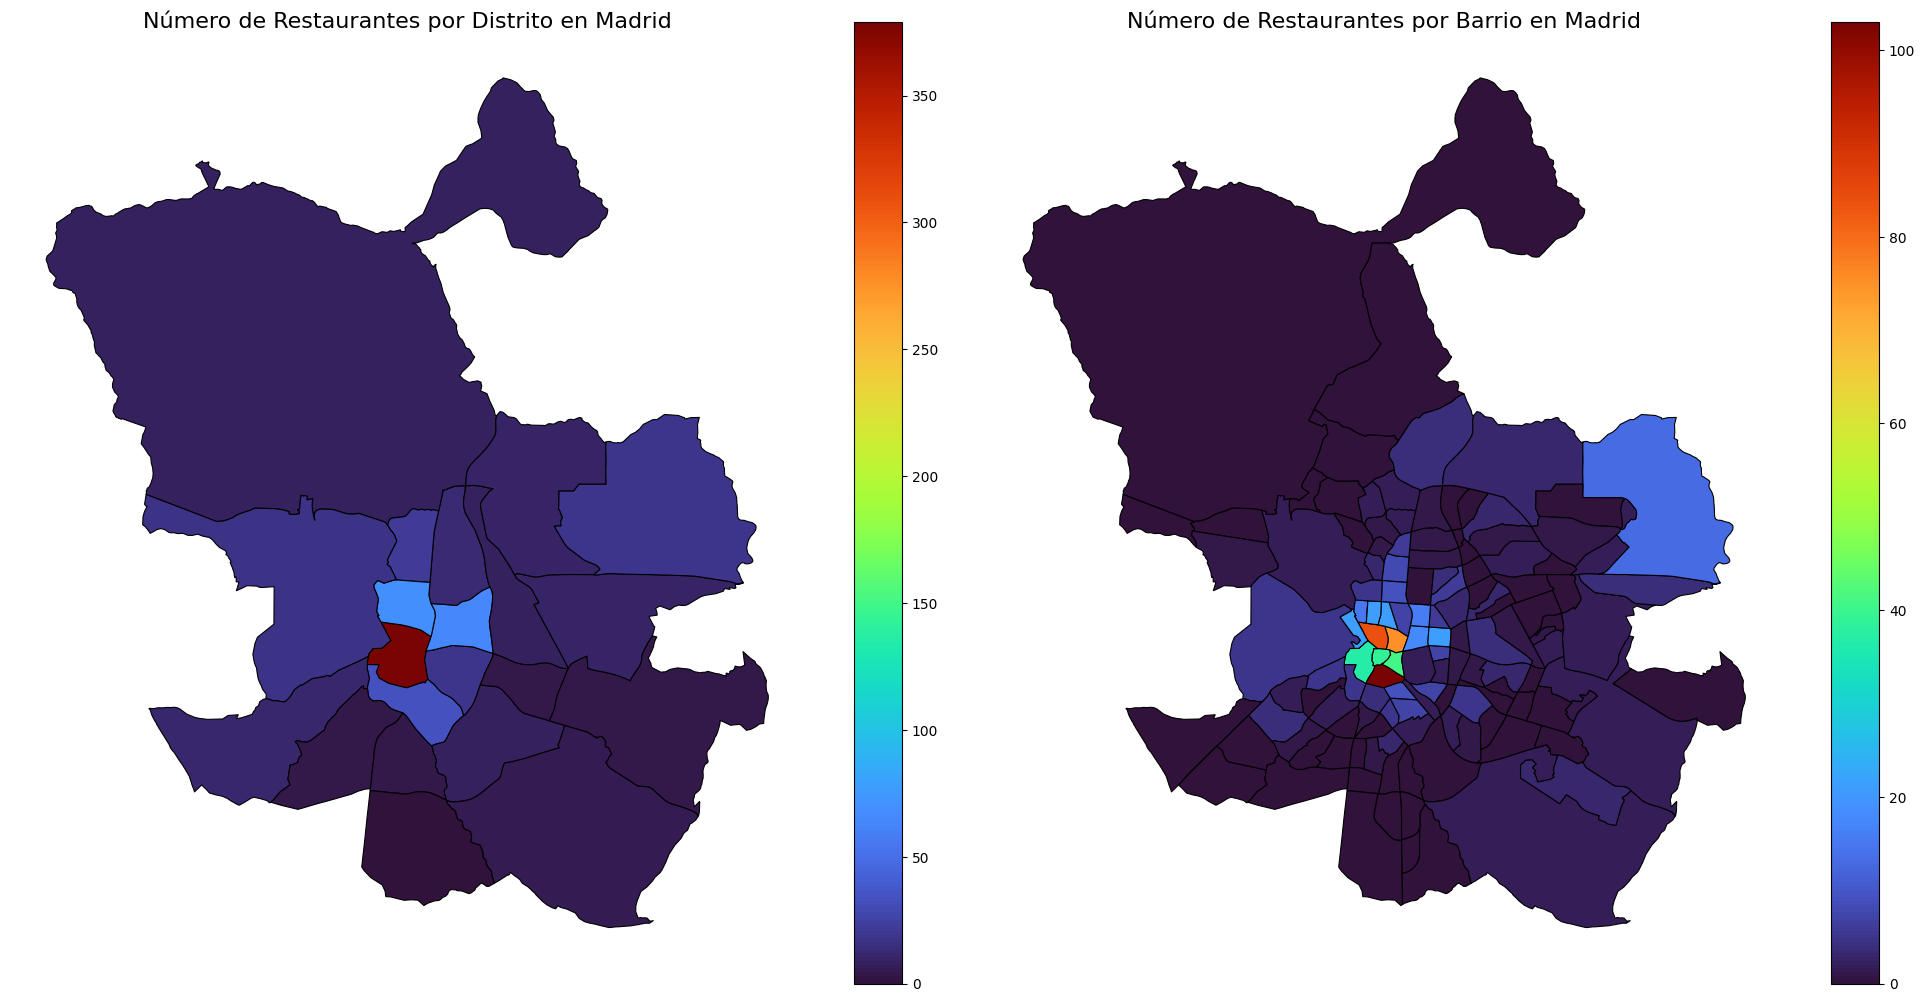

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: Restaurantes por distrito
madrid.plot(column='count', cmap='turbo', linewidth=0.8, ax=axes[0], edgecolor='black', legend=True)
axes[0].set_title('Número de Restaurantes por Distrito en Madrid', fontsize=16)
axes[0].axis('off')

# Segundo gráfico: Restaurantes por barrio
barrios_madrid.plot(column='count', cmap='turbo', linewidth=0.8, ax=axes[1], edgecolor='black', legend=True)
axes[1].set_title('Número de Restaurantes por Barrio en Madrid', fontsize=16)
axes[1].axis('off')

plt.tight_layout()  # Ajusta el espacio entre los subplots
plt.show()

# Mapa de afluencia (número de ratings de media por distrito)

In [96]:
df_distritos["NOMBRE_BARRIO"] = df_barrios["NOMBRE_BARRIO"]

In [97]:
df = df_distritos
df

,Name,Address,Lat,Long,Number of Ratings,Restaurant Rating,Type of Restaurant,Number of Bookmarks,Price Range,Phone Number,Website,Instagram,Facebook,Timetable,url,NOMBRE_DISTRITO,NOMBRE_BARRIO
id,,,,,,,,,,,,,,,,,
1,Freedom Cakes Diner,"Calle Cádiz 7,Madrid,Spain,28004",40.415876,-3.702805,470.0,4.5,['International'],766,Moderado,+34-910741347,http://www.freedomcakes.es/,http://www.instagram.com/freedomcakes,http://facebook.com/Freedomcakesvegan,"{'Monday': '08:00 - 00:00', 'Tuesday': '08:00 ...",https://www.happycow.net/reviews/freedom-cakes...,Centro,Sol
2,Mad Mad Vegan - Chueca,"Calle Pelayo 19,Madrid,Spain,28004",40.422698,-3.698609,410.0,5.0,"['American', 'Mexican']",612,Moderado,+34-914442077,https://madmadvegan.com/,http://www.instagram.com/madmadvegan,http://facebook.com/MADMADVEGAN,"{'Monday': '13:00 - 00:00', 'Tuesday': '13:00 ...",https://www.happycow.net/reviews/mad-mad-madri...,Centro,Justicia
3,Frutas Prohibidas,"Calle del Conde Duque, 26,Madrid,Spain,28015",40.427467,-3.710349,241.0,5.0,"['International', 'Fusion']",555,Moderado,+34-911525533,http://www.frutasprohibidas.com/,http://www.instagram.com/frutasprohibidasbar,http://facebook.com/frutasprohibidasbar,"{'Monday': 'Closed', 'Tuesday': 'Closed', 'Wed...",https://www.happycow.net/reviews/frutas-prohib...,Centro,Universidad
4,Mad Mad Vegan - Lavapiés,"Lavapiés 16,Madrid,Spain,28012",40.411113,-3.703039,216.0,4.5,"['American', 'Mexican']",465,Moderado,+34-910665299,https://madmadvegan.com/,http://www.instagram.com/madmadvegan,http://facebook.com/MADMADVEGAN,"{'Monday': '13:00 - 00:00', 'Tuesday': '13:00 ...",https://www.happycow.net/reviews/mad-mad-vegan...,Centro,Embajadores
5,Flower Burger,"Calle Luchana 13, Chamberí,Madrid,Spain,28010",40.430001,-3.701037,14.0,4.5,"['American', 'Western']",47,Barato,+34-910328968,https://www.flowerburger.it/,http://www.instagram.com/flowerburger_es,http://facebook.com/flowerburger.it,"{'Monday': '13:00 - 16:30, 19:30 - 23:30', 'Tu...",https://www.happycow.net/reviews/flower-burger...,Chamberi,Ríos Rosas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,Morgano Crafted Beers,"Alamo 2, Boadilla del Monte, Madrid, Spain, 28660",40.405759,-3.876917,1.0,4.0,"['Middle Eastern', 'Spanish']",2,Barato,+34-695635423,No website,No instagram,http://facebook.com/MorganoCraftedBeers,"{'Monday': '19:00 - 01:00', 'Tuesday': '19:00 ...",https://www.happycow.net/reviews/morgano-craft...,NaN,NaN
745,Adagio Gelateria,"Avenida de Adolfo Suárez, 7, Boadilla Del Mont...",40.405413,-3.876999,1.0,4.0,['Italian'],0,No price range,+34-912859853,No website,http://www.instagram.com/adagiogelateria,http://facebook.com/adagiogelateria,"{'Monday': '10:00 - 22:30', 'Tuesday': '10:00 ...",https://www.happycow.net/reviews/adagio-gelate...,NaN,NaN
746,La Huella Vegana,"Calle de las Trece Rosas, 2,Rivas-vaciamadrid,...",40.376390,-3.540020,31.0,4.5,"['Western', 'Spanish']",42,Moderado,+34-917139958,http://www.lahuellavegana.com/,No instagram,http://facebook.com/lahuellavegana,"{'Monday': '08:30 - 23:00', 'Tuesday': '08:30 ...",https://www.happycow.net/reviews/la-huella-riv...,NaN,NaN


In [98]:
ratings_by_district = df.groupby('NOMBRE_DISTRITO')['Number of Ratings'].sum().sort_values(ascending=False)
restaurants_by_district = df.groupby('NOMBRE_DISTRITO').size()
district_stats = pd.DataFrame({
    'Total Ratings': ratings_by_district,
    'Number of Restaurants': restaurants_by_district
})
district_stats['Ratings per Restaurant'] = district_stats['Total Ratings'] / district_stats['Number of Restaurants']
district_stats.loc["Villaverde"] = 0
district_stats

,Total Ratings,Number of Restaurants,Ratings per Restaurant
NOMBRE_DISTRITO,,,
Arganzuela,354.0,34,10.411765
Barajas,60.0,18,3.333333
Carabanchel,53.0,4,13.250000
Centro,7190.0,379,18.970976
Chamartin,35.0,13,2.692308
Chamberi,619.0,69,8.971014
Ciudad Lineal,20.0,8,2.500000
Fuencarral-El Pardo,30.0,8,3.750000
Hortaleza,24.0,9,2.666667


In [99]:
madrid = madrid.drop(columns=["count"])
madrid = madrid.merge(district_stats, left_on="NOMBRE_DISTRITO", right_on="NOMBRE_DISTRITO")
madrid

,geometry,NOMBRE_DISTRITO,Total Ratings,Number of Restaurants,Ratings per Restaurant
0,"POLYGON ((441184.784 4473200.78, 441181.244 44...",Centro,7190.0,379,18.970976
1,"POLYGON ((440272.919 4472969.567, 440350.318 4...",Arganzuela,354.0,34,10.411765
2,"POLYGON ((443652.149 4473312.6, 443560.739 447...",Retiro,207.0,19,10.894737
3,"POLYGON ((444075.178 4476611.827, 444057.808 4...",Salamanca,437.0,65,6.723077
4,"POLYGON ((442904.114 4481525.212, 442901.02 44...",Chamartin,35.0,13,2.692308
5,"POLYGON ((440863.995 4480662.221, 440875.945 4...",Tetuan,82.0,21,3.904762
6,"POLYGON ((441380.014 4477514.037, 441330.993 4...",Chamberi,619.0,69,8.971014
7,"POLYGON ((445503.158 4498783.075, 445674.188 4...",Fuencarral-El Pardo,30.0,8,3.750000
8,"POLYGON ((432093.685 4480171.575, 432166.365 4...",Moncloa-Aravaca,156.0,17,9.176471
9,"POLYGON ((438689.611 4473668.522, 438753.889 4...",Latina,37.0,11,3.363636


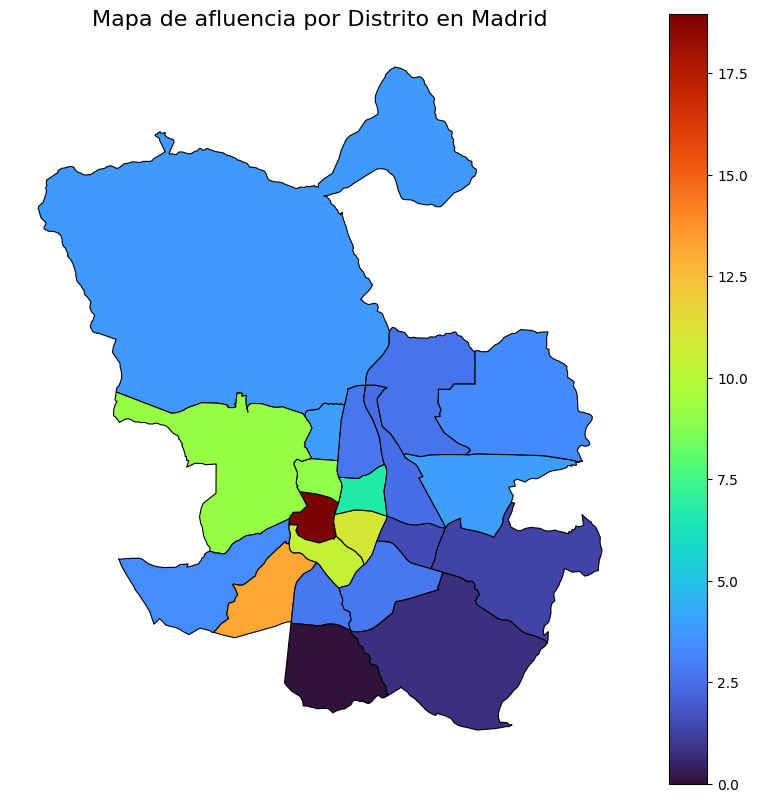

In [100]:
fig2, ax = plt.subplots(1, 1, figsize=(10, 10))
madrid.plot(column='Ratings per Restaurant', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='black', legend=True)
ax.set_title('Mapa de afluencia por Distrito en Madrid', fontsize=16)
ax.axis('off')
plt.show()